# 03 - Minimum Eigen Optimizer

#### Uncomment the cell below to pip install the necessary modules if not already installed

#### Note: Works with Qiskit Version 1.4.1 and Quantum Rings Qiskit Toolkit Version 0.1.10

In [1]:
# %pip install qiskit==1.4.1
# %pip install quantumrings-toolkit-qiskit==0.1.10
# %pip install qiskit-algorithms
# %pip install qiskit-optimization
# %pip install numpy

#### Restart the kernel after installing any of the missing packages

### Introduction

An interesting class of optimization problems to be addressed by quantum computing are [Quadratic Unconstrained Binary Optimization (QUBO)](https://en.wikipedia.org/wiki/Quadratic_unconstrained_binary_optimization) problems. Finding the solution to a QUBO problem is equivalent to finding the ground state of a corresponding Ising Hamiltonian, which is an important problem not only in optimization, but also in quantum chemistry and physics. For this translation, the binary variables taking values in $\{0, 1\}$ are replaced by spin variables taking values in $\{-1, +1\}$, which allows one to replace the resulting spin variables by Pauli Z matrices, and thus, an Ising Hamiltonian. For more details on this mapping we refer to a paper on [Ising Formulations](https://arxiv.org/abs/1302.5843). 

Qiskit optimization provides automatic conversion from a suitable `QuadraticProgram` to an Ising Hamiltonian, which then allows leveraging all the `SamplingMinimumEigensolver` implementations, such as:

- `SamplingVQE`
- `QAOA`
- `NumPyMinimumEigensolver` (classical exact method)

> **Note 1**: `MinimumEigenOptimizer` does not support `qiskit_algorithms.VQE`, but `qiskit_algorithms.SamplingVQE` can be used instead.
> 
> **Note 2**: `MinimumEigenOptimizer` can use `NumPyMinimumEigensolver` as an exception case though it inherits `MinimumEigensolver` (not `SamplingMinimumEigensolver`).

Qiskit optimization provides a `MinimumEigenOptimizer` class, which wraps the translation to an Ising Hamiltonian (in Qiskit Terra also called `SparsePauliOp`), the call to a `MinimumEigensolver`, and the translation of the results back to an `OptimizationResult`.

In the following we first illustrate the conversion from a `QuadraticProgram` to a `SparsePauliOp` and then show how to use the `MinimumEigenOptimizer` with different `MinimumEigensolver`s to solve a given `QuadraticProgram`. The algorithms in Qiskit optimization automatically try to convert a given problem to the supported problem class if possible, for instance, the `MinimumEigenOptimizer` will automatically translate integer variables to binary variables or add linear equality constraints as a quadratic penalty term to the objective. It should be mentioned that a `QiskitOptimizationError` will be thrown if conversion of a quadratic program with integer variables is attempted.

The circuit depth of `QAOA` potentially has to be increased with the problem size, which might be prohibitive for near-term quantum devices. A possible workaround is Recursive QAOA as described in the paper [Obstacles to State Preparation](https://arxiv.org/abs/1910.08980). Qiskit optimization generalizes this concept to the `RecursiveMinimumEigenOptimizer`, which is introduced at the end of this tutorial.

In [2]:
# This code is from the tutorial at:
# https://qiskit-community.github.io/qiskit-optimization/tutorials/03_minimum_eigen_optimizer.html

### Converting a QUBO to a SparsePauliOp

We'll start by importing the necessary modules and functions for creating our QUBO problem with `QuadraticProgram`. Instead of using the `Sampler` from Qiskit, we will import the `Sampler` from the Quantum Rings Qiskit Toolkit.

In [3]:
from qiskit_algorithms.utils import algorithm_globals
from qiskit_algorithms import QAOA, NumPyMinimumEigensolver
from qiskit_algorithms.optimizers import COBYLA

from quantumrings.toolkit.qiskit import QrSamplerV1 as Sampler

from qiskit_optimization.algorithms import (
    MinimumEigenOptimizer,
    RecursiveMinimumEigenOptimizer,
    SolutionSample,
    OptimizationResultStatus,
)
from qiskit_optimization import QuadraticProgram
from qiskit.visualization import plot_histogram
from typing import List, Tuple
import numpy as np

In [4]:
# create a QUBO
qubo = QuadraticProgram()
qubo.binary_var("x")
qubo.binary_var("y")
qubo.binary_var("z")
qubo.minimize(linear=[1, -2, 3], quadratic={("x", "y"): 1, ("x", "z"): -1, ("y", "z"): 2})
print(qubo.prettyprint())

Problem name: 

Minimize
  x*y - x*z + 2*y*z + x - 2*y + 3*z

Subject to
  No constraints

  Binary variables (3)
    x y z



Now we will translate this QUBO into an Ising operator. This results not only in a `SparsePauliOp` but also in a constant offset to be taken into account as it will shift the resulting value.

In [5]:
op, offset = qubo.to_ising()
print("offset: {}".format(offset))
print("operator:")
print(op)

offset: 1.5
operator:
SparsePauliOp(['IIZ', 'IZI', 'ZII', 'IZZ', 'ZIZ', 'ZZI'],
              coeffs=[-0.5 +0.j,  0.25+0.j, -1.75+0.j,  0.25+0.j, -0.25+0.j,  0.5 +0.j])


Sometimes a `QuadraticProgram` might also directly be given in the form of a `SparsePauliOp`. For such cases, Qiskit optimization also provides a translator from a `SparsePauliOp` back to a `QuadraticProgram`, which we illustrate in the following.

In [6]:
qp = QuadraticProgram()
qp.from_ising(op, offset, linear=True)
print(qp.prettyprint())

Problem name: 

Minimize
  x0*x1 - x0*x2 + 2*x1*x2 + x0 - 2*x1 + 3*x2

Subject to
  No constraints

  Binary variables (3)
    x0 x1 x2



This translator allows, for instance, one to translate a `SparsePauliOp` to a `QuadraticProgram` and then solve the problem with other algorithms that are not based on the Ising Hamiltonian representation, such as the `GroverOptimizer`.

### Solving a QUBO with the MinimumEigenOptimizer

We start by initializing the `MinimumEigensolver` we want to use. This will come from `NumPyMinimumEigensolver`.

In [7]:
algorithm_globals.random_seed = 10598

qaoa_mes = QAOA(sampler=Sampler(), optimizer=COBYLA(), initial_point=[0.0, 0.0])
exact_mes = NumPyMinimumEigensolver()

We then use the `MinimumEigensolver` to create the `MinimumEigenOptimizer`.

In [8]:
qaoa = MinimumEigenOptimizer(qaoa_mes)  # using QAOA
exact = MinimumEigenOptimizer(exact_mes)  # using the exact classical numpy minimum eigen solver

We first use the `MinimumEigenOptimizer` based on the classical exact `NumPyMinimumEigensolver` to get the optimal benchmark solution for this small example.

In [9]:
exact_result = exact.solve(qubo)
print(exact_result.prettyprint())

objective function value: -2.0
variable values: x=0.0, y=1.0, z=0.0
status: SUCCESS


Next, we apply the `MinimumEigenOptimizer` based on `QAOA` to the same problem.

In [10]:
qaoa_result = qaoa.solve(qubo)
print(qaoa_result.prettyprint())

objective function value: -2.0
variable values: x=0.0, y=1.0, z=0.0
status: SUCCESS


### Analysis of Samples

`OptimizationResult` provides useful information in the form of `SolutionSample`s (here denoted as `samples`). Each `SolutionSample` contains information about the input values (`x`), the corresponding objective function value (`fval`), the fraction of samples corresponding to that input (`probability`), and the solution `status` (`SUCCESS`, `FAILURE`, `INFEASIBLE`). Multiple samples corresponding to the same input are consolidated into a single `SolutionSample` (with its `probability` attribute being the aggregate fraction of samples represented by that `SolutionSample`).

In [11]:
print("variable order:", [var.name for var in qaoa_result.variables])
for s in qaoa_result.samples:
    print(s)

variable order: ['x', 'y', 'z']
SolutionSample(x=array([0., 1., 0.]), fval=np.float64(-2.0), probability=0.4521484375, status=<OptimizationResultStatus.SUCCESS: 0>)
SolutionSample(x=array([0., 0., 0.]), fval=np.float64(0.0), probability=0.2333984375, status=<OptimizationResultStatus.SUCCESS: 0>)
SolutionSample(x=array([1., 1., 0.]), fval=np.float64(0.0), probability=0.107421875, status=<OptimizationResultStatus.SUCCESS: 0>)
SolutionSample(x=array([1., 0., 0.]), fval=np.float64(1.0), probability=0.1083984375, status=<OptimizationResultStatus.SUCCESS: 0>)
SolutionSample(x=array([0., 0., 1.]), fval=np.float64(3.0), probability=0.029296875, status=<OptimizationResultStatus.SUCCESS: 0>)
SolutionSample(x=array([1., 0., 1.]), fval=np.float64(3.0), probability=0.037109375, status=<OptimizationResultStatus.SUCCESS: 0>)
SolutionSample(x=array([0., 1., 1.]), fval=np.float64(3.0), probability=0.03125, status=<OptimizationResultStatus.SUCCESS: 0>)
SolutionSample(x=array([1., 1., 1.]), fval=np.float

We may also want to filter samples according to their status or probabilities.

In [12]:
def get_filtered_samples(
    samples: List[SolutionSample],
    threshold: float = 0,
    allowed_status: Tuple[OptimizationResultStatus] = (OptimizationResultStatus.SUCCESS,),
):
    res = []
    for s in samples:
        if s.status in allowed_status and s.probability > threshold:
            res.append(s)

    return res

In [13]:
filtered_samples = get_filtered_samples(
    qaoa_result.samples, threshold=0.005, allowed_status=(OptimizationResultStatus.SUCCESS,)
)
for s in filtered_samples:
    print(s)

SolutionSample(x=array([0., 1., 0.]), fval=np.float64(-2.0), probability=0.4521484375, status=<OptimizationResultStatus.SUCCESS: 0>)
SolutionSample(x=array([0., 0., 0.]), fval=np.float64(0.0), probability=0.2333984375, status=<OptimizationResultStatus.SUCCESS: 0>)
SolutionSample(x=array([1., 1., 0.]), fval=np.float64(0.0), probability=0.107421875, status=<OptimizationResultStatus.SUCCESS: 0>)
SolutionSample(x=array([1., 0., 0.]), fval=np.float64(1.0), probability=0.1083984375, status=<OptimizationResultStatus.SUCCESS: 0>)
SolutionSample(x=array([0., 0., 1.]), fval=np.float64(3.0), probability=0.029296875, status=<OptimizationResultStatus.SUCCESS: 0>)
SolutionSample(x=array([1., 0., 1.]), fval=np.float64(3.0), probability=0.037109375, status=<OptimizationResultStatus.SUCCESS: 0>)
SolutionSample(x=array([0., 1., 1.]), fval=np.float64(3.0), probability=0.03125, status=<OptimizationResultStatus.SUCCESS: 0>)


If we want to obtain a better perspective of the results, statistics is very helpful, both with respect to the objective function values and their respective probabilities. Thus, mean and standard deviation are the very basics for understanding the results.

In [14]:
fvals = [s.fval for s in qaoa_result.samples]
probabilities = [s.probability for s in qaoa_result.samples]

In [15]:
np.mean(fvals)

np.float64(1.5)

In [16]:
np.std(fvals)

np.float64(1.9364916731037085)

Now that we've crunched all the numbers, visualization will help us process the information, especially as an early-analysis approach.

In [17]:
samples_for_plot = {
    " ".join(f"{qaoa_result.variables[i].name}={int(v)}" for i, v in enumerate(s.x)): s.probability
    for s in filtered_samples
}
samples_for_plot

{'x=0 y=1 z=0': 0.4521484375,
 'x=0 y=0 z=0': 0.2333984375,
 'x=1 y=1 z=0': 0.107421875,
 'x=1 y=0 z=0': 0.1083984375,
 'x=0 y=0 z=1': 0.029296875,
 'x=1 y=0 z=1': 0.037109375,
 'x=0 y=1 z=1': 0.03125}

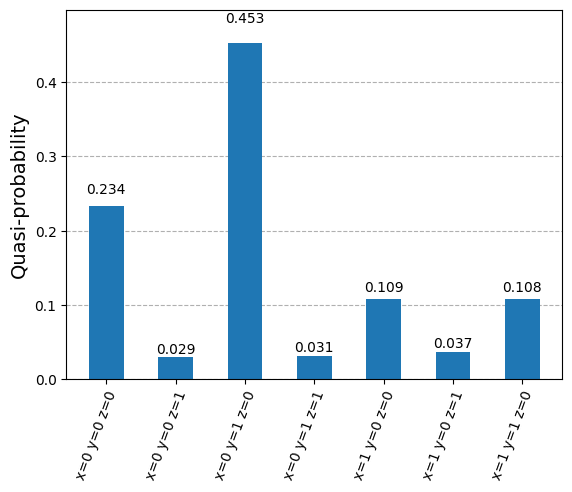

In [18]:
plot_histogram(samples_for_plot)

In the plot above, we see the Quasi-Probabilities for the various states starting with state `000` up to state `110`. These correspond with the values of our `x`, `y`, and `z` variables. Let's take a look at this problem using a `RecursiveMinimumEigenOptimizer`.

### RecursiveMinimumEigenOptimizer

The `RecursiveMinimumEigenOptimizer` takes a `MinimumEigenOptimizer` as input and applies the recursive optimization scheme to reduce the size of the problem one variable at a time. Once the size of the generated intermediate problem is below a given threshold (`min_num_vars`), the `RecursiveMinimumEigenOptimizer` uses another solver (`min_num_vars_optimizer`), e.g., an exact classical solver such as CPLEX or the `MinimumEigenOptimizer` based on the `NumPyMinimumEigensolver`.

In the following, we show how to use the `RecursiveMinimumEigenOptimizer` using the two `MinimumEigenOptimizer`s introduced before.

We will start by constructing the `RecursiveMinimumEigenOptimizer` such that it reduces the problem size from 3 variables to 1 variable and then uses the exact solver for the last variable. Then we call `solve` to optimize the considered problem.

In [24]:
rqaoa = RecursiveMinimumEigenOptimizer(qaoa, min_num_vars=1, min_num_vars_optimizer=exact)

In [25]:
rqaoa_result = rqaoa.solve(qubo)
print(rqaoa_result.prettyprint())

objective function value: -2.0
variable values: x=0.0, y=1.0, z=0.0
status: SUCCESS


In [26]:
filtered_samples = get_filtered_samples(
    rqaoa_result.samples, threshold=0.005, allowed_status=(OptimizationResultStatus.SUCCESS,)
)

In [27]:
samples_for_plot = {
    " ".join(f"{rqaoa_result.variables[i].name}={int(v)}" for i, v in enumerate(s.x)): s.probability
    for s in filtered_samples
}
samples_for_plot

{'x=0 y=1 z=0': 1.0}

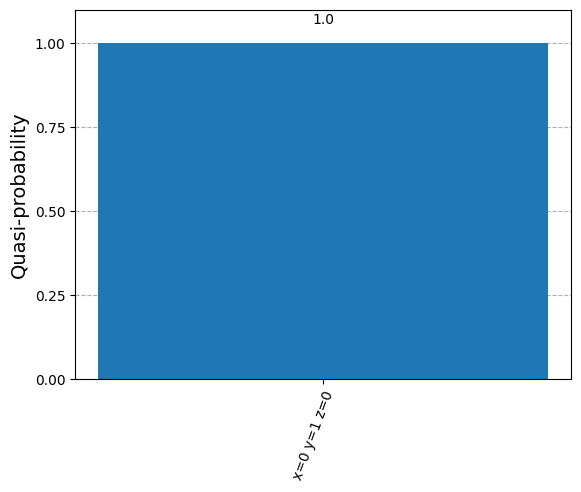

In [28]:
plot_histogram(samples_for_plot)

### Conclusion

Congratulations! You've created a Minimum EigenOptimizer using Qiskit and the Quantum Rings Toolkit. Notice in this last graph, that the state which had the highest probability before the recursive method is now the only state and has a probability of 1. This is the result of the recursive method and the optimization of only one variable instead of three variables. Feel free to look at the papers linked at the start of this notebook for more detailed information on this topic!